In [1]:
import os, pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt

tqdm.pandas()  # Enable tqdm for Pandas apply
model = SentenceTransformer('all-MiniLM-L6-v2')
newsgroups_pkl = '20newsgroups.pkl'

D:\ProgramData\Anaconda3\envs\graph_env\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
D:\ProgramData\Anaconda3\envs\graph_env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
if os.path.exists(newsgroups_pkl):
    df_20newsgroups = pd.read_pickle(newsgroups_pkl)
else:
    # Load the dataset and generate the embeddings
    newsgroups = fetch_20newsgroups(subset='all', categories=None)

    # Convert to a DataFrame
    df_20newsgroups = pd.DataFrame({
        'text': newsgroups.data,
        'target': newsgroups.target
    })

    # Map the numeric target to the descriptive topic name
    df_20newsgroups['target_name'] = df_20newsgroups['target'].apply(
        lambda x: newsgroups.target_names[x]
    )
    
    # 4. Extract the "top-level" category (e.g., 'comp.graphics' → 'comp')
    df_20newsgroups['top_level'] = df_20newsgroups['target_name'].apply(lambda x: x.split('.', 1)[0])
    
    embeddings = []
    for index, row in tqdm(df_20newsgroups.iterrows(), total=df_20newsgroups.shape[0]):
        text = row['text']
        embedding = model.encode(text)
        embeddings.append(embedding)

    df_20newsgroups['embedding'] = embeddings
    df_20newsgroups.to_pickle(newsgroups_pkl)
    
set_of_target_names = set(list(df_20newsgroups['target_name']))
print('There are', len(set_of_target_names), 'target names:\n', set_of_target_names)

print('df_20newsgroups.shape:', df_20newsgroups.shape)
print('df_20newsgroups.info():', df_20newsgroups.info())
df_20newsgroups.head()

  0%|                                                                                        | 0/18846 [00:00<?, ?it/s]D:\ProgramData\Anaconda3\envs\graph_env\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|████████████████████████████████████████████████████████████████████████████| 18846/18846 [04:02<00:00, 77.62it/s]


There are 20 target names:
 {'comp.sys.mac.hardware', 'comp.windows.x', 'sci.space', 'talk.politics.misc', 'talk.religion.misc', 'sci.electronics', 'talk.politics.guns', 'soc.religion.christian', 'rec.autos', 'rec.motorcycles', 'talk.politics.mideast', 'alt.atheism', 'comp.sys.ibm.pc.hardware', 'comp.graphics', 'comp.os.ms-windows.misc', 'misc.forsale', 'rec.sport.hockey', 'sci.crypt', 'rec.sport.baseball', 'sci.med'}
df_20newsgroups.shape: (18846, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         18846 non-null  object
 1   target       18846 non-null  int32 
 2   target_name  18846 non-null  object
 3   top_level    18846 non-null  object
 4   embedding    18846 non-null  object
dtypes: int32(1), object(4)
memory usage: 662.7+ KB
df_20newsgroups.info(): None


,text,target,target_name,top_level,embedding
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey,rec,"[-0.00016728362, 0.0009191562, 0.0026798474, 8..."
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3,comp.sys.ibm.pc.hardware,comp,"[0.014085343, 0.040674016, -0.023832878, -0.06..."
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17,talk.politics.mideast,talk,"[-0.00508196, 0.10994208, -0.027346618, -0.062..."
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3,comp.sys.ibm.pc.hardware,comp,"[-0.07404837, -0.04057084, -0.017204672, -0.01..."
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4,comp.sys.mac.hardware,comp,"[-0.05614912, -0.051996835, -0.08028872, -0.01..."


In [3]:
# Convert list-of-lists into a 2D array (assuming each embedding is a vector of fixed size)
X = np.vstack(df_20newsgroups['embedding'].values)

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(X)

# Assign cluster labels back to the DataFrame
df_20newsgroups['cluster'] = kmeans.labels_

print('df_20newsgroups.shape:', df_20newsgroups.shape)
print('df_20newsgroups.info():', df_20newsgroups.info())
df_20newsgroups.head()

D:\ProgramData\Anaconda3\envs\graph_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


df_20newsgroups.shape: (18846, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         18846 non-null  object
 1   target       18846 non-null  int32 
 2   target_name  18846 non-null  object
 3   top_level    18846 non-null  object
 4   embedding    18846 non-null  object
 5   cluster      18846 non-null  int32 
dtypes: int32(2), object(4)
memory usage: 736.3+ KB
df_20newsgroups.info(): None


,text,target,target_name,top_level,embedding,cluster
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey,rec,"[-0.00016728362, 0.0009191562, 0.0026798474, 8...",6
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3,comp.sys.ibm.pc.hardware,comp,"[0.014085343, 0.040674016, -0.023832878, -0.06...",4
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17,talk.politics.mideast,talk,"[-0.00508196, 0.10994208, -0.027346618, -0.062...",1
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3,comp.sys.ibm.pc.hardware,comp,"[-0.07404837, -0.04057084, -0.017204672, -0.01...",4
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4,comp.sys.mac.hardware,comp,"[-0.05614912, -0.051996835, -0.08028872, -0.01...",4


In [4]:

# 5. Reduce embeddings to 2D via PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
df_20newsgroups['pca1'] = X_pca[:, 0]
df_20newsgroups['pca2'] = X_pca[:, 1]

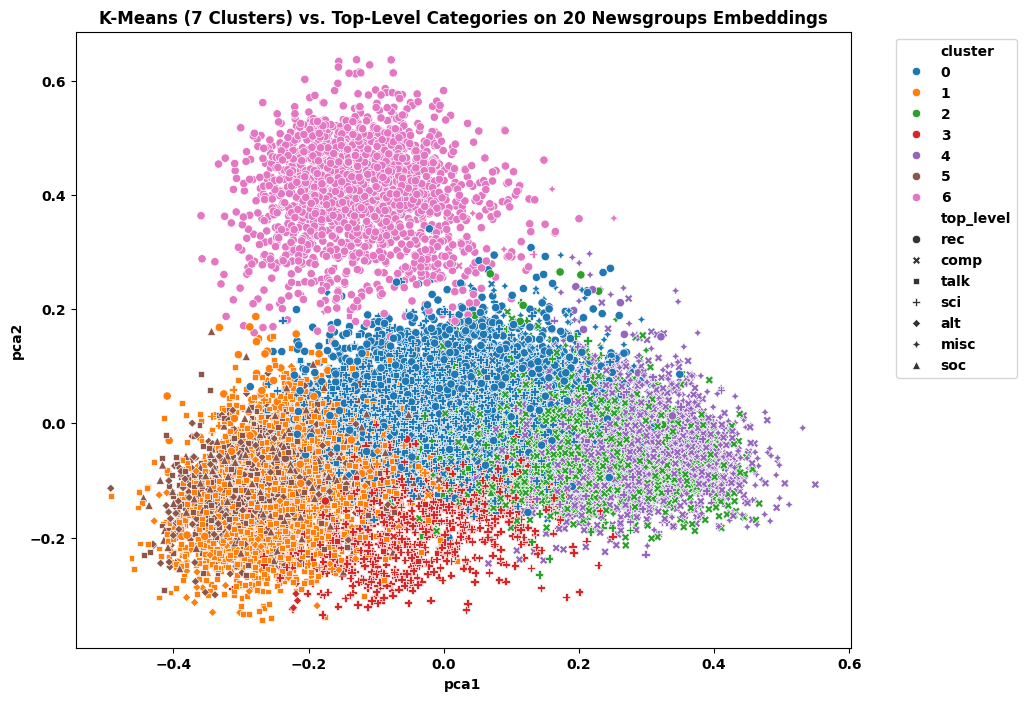

In [5]:

# 6. Plot the scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='pca1',
    y='pca2',
    hue='cluster',            # color by K-Means cluster
    style='top_level',        # marker style by top-level category
    data=df_20newsgroups,
    palette='tab10'
)
plt.title('K-Means (7 Clusters) vs. Top-Level Categories on 20 Newsgroups Embeddings')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

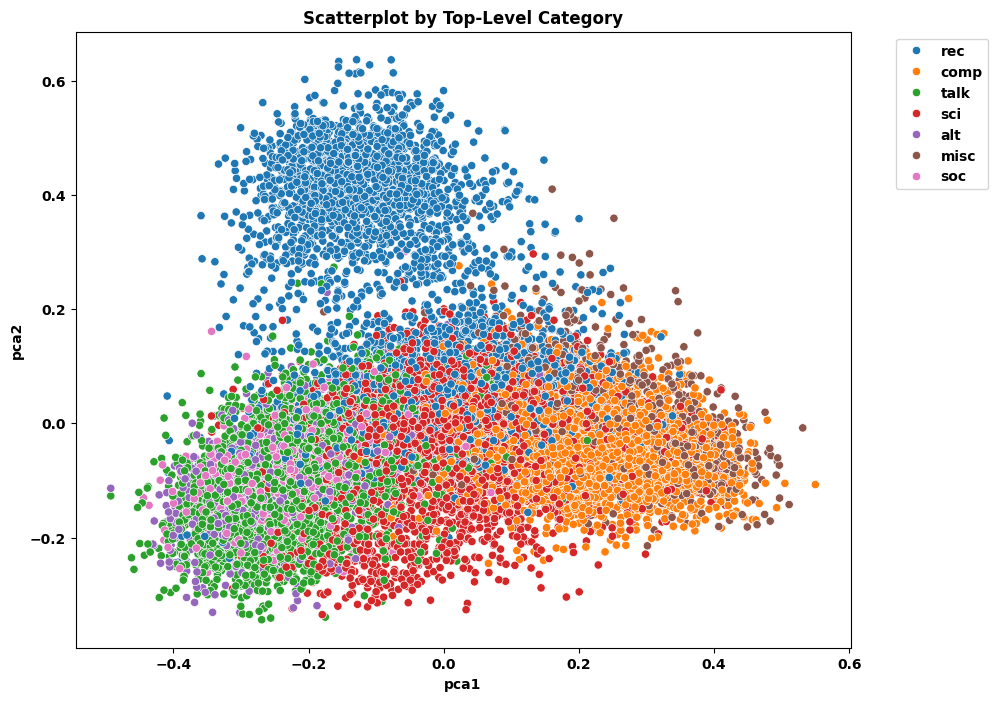

In [6]:
# 1. Scatterplot of the original top-level categories
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='pca1',
    y='pca2',
    hue='top_level',
    data=df_20newsgroups,
    palette='tab10'
)
plt.title('Scatterplot by Top-Level Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

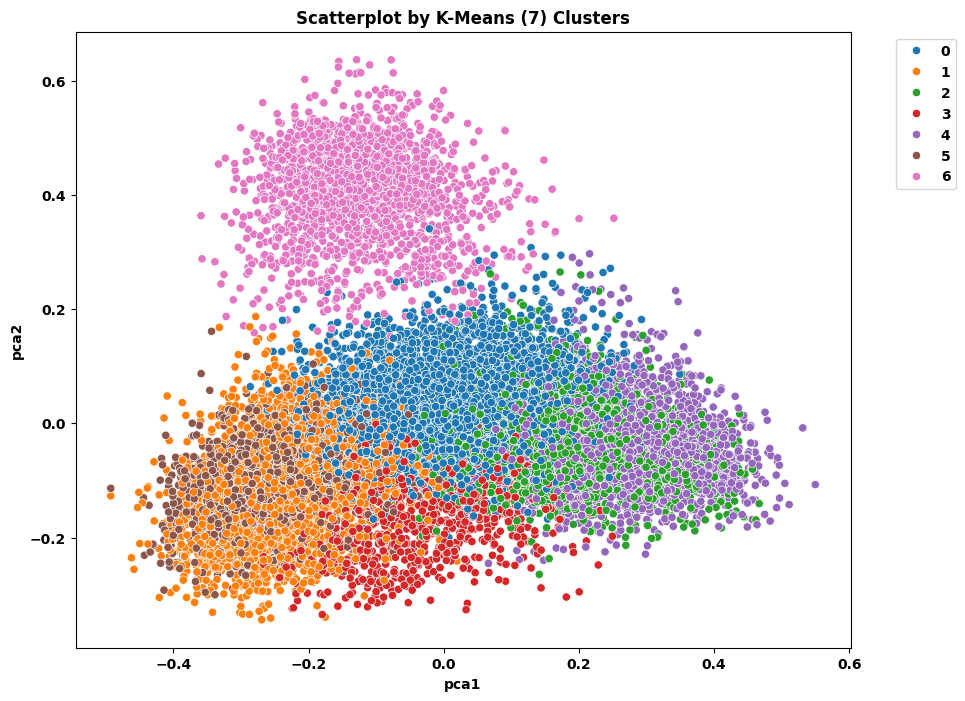

In [7]:
# 2. Scatterplot of the K-Means clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='pca1',
    y='pca2',
    hue='cluster',
    data=df_20newsgroups,
    palette='tab10'
)
plt.title('Scatterplot by K-Means (7) Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [10]:
# 2. Run K-Means with 4 clusters on the filtered data
X_filtered = np.vstack(df_filtered['embedding'].values)

kmeans_4 = KMeans(n_clusters=4, random_state=42)
kmeans_4.fit(X_filtered)

# Add the new 4-cluster labels to the filtered DataFrame
df_filtered['cluster_4'] = kmeans_4.labels_

# 3. (Optional) Re-run PCA on just the filtered data 
#    for a fresh 2D scatterplot
pca_filtered = PCA(n_components=2, random_state=42)
X_filtered_pca = pca_filtered.fit_transform(X_filtered)

df_filtered['pca1_4'] = X_filtered_pca[:, 0]
df_filtered['pca2_4'] = X_filtered_pca[:, 1]

D:\ProgramData\Anaconda3\envs\graph_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\temp\ipykernel_6424\3583436631.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cluster_4'] = kmeans_4.labels_
C:\temp\ipykernel_6424\3583436631.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fi

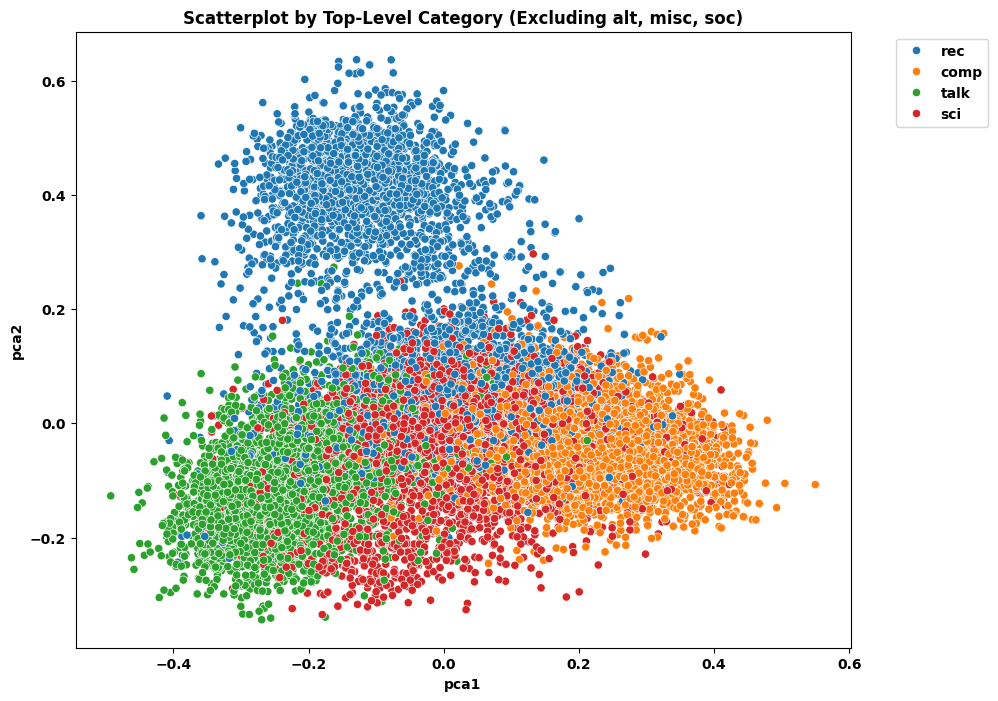

In [8]:
# 1. Filter out rows where top_level is in ['alt', 'misc', 'soc']
df_filtered = df_20newsgroups[
    ~df_20newsgroups['top_level'].isin(['alt', 'misc', 'soc'])
]

# 2. Scatterplot of top-level categories (minus alt, misc, soc)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='pca1',
    y='pca2',
    hue='top_level',
    data=df_filtered,
    palette='tab10'
)
plt.title('Scatterplot by Top-Level Category (Excluding alt, misc, soc)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

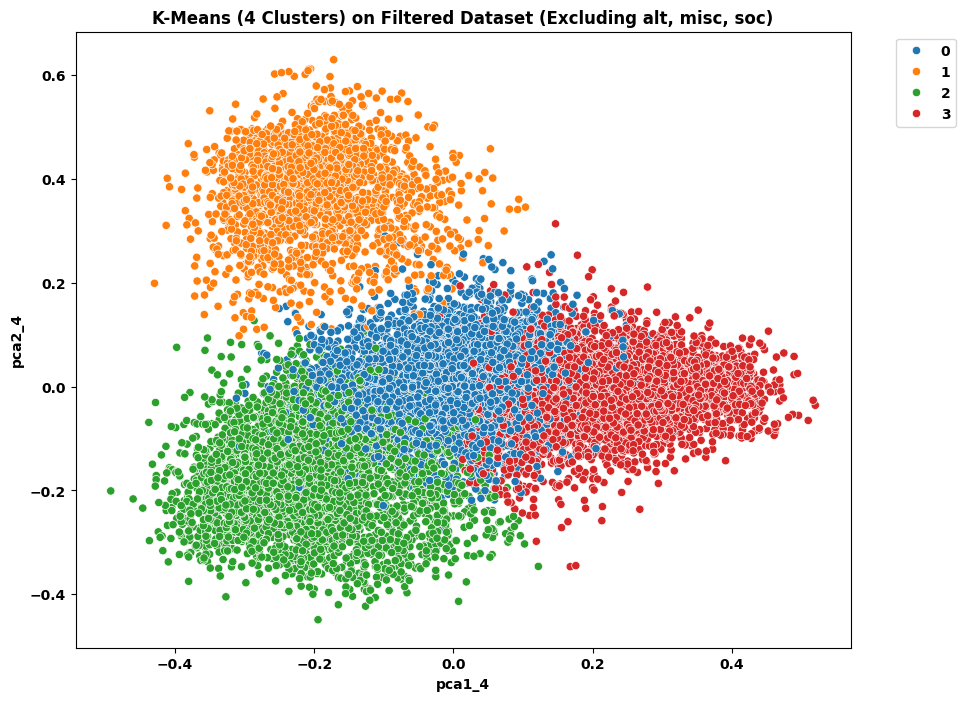

In [11]:
# 4. Plot the results, colored by the new 4 clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='pca1_4',
    y='pca2_4',
    hue='cluster_4',
    data=df_filtered,
    palette='tab10'
)
plt.title('K-Means (4 Clusters) on Filtered Dataset (Excluding alt, misc, soc)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()